# Personal Project #1 : Personal Finance and Budgeting
* In this project, a finance statement dataset in CSV format is downloaded from "E for Excel" for analysis and future financial related predictions such as the expenditure which we will assume is equivalent to the amount of money withdrawn from the bank account.
* The predictions will be done by a trained linear regression model where it assumes a linear relationship between the years and the amount of money spent/withdrawn
* Creating this allows users to observe their spendings and possibly improve their budgeting in the long term
* Link to datasets: https://eforexcel.com/wp/downloads-20-sample-csv-files-data-sets-for-testing-till-2-million-records-bank 

### 1. Import necessary libraries and read the financial statement to a data frame

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read csv file of bank statement records (Link: https://eforexcel.com/wp/downloads-20-sample-csv-files-data-sets-for-testing-till-2-million-records-bank-transactions/) 
df = pd.read_csv("5000000 BT Records.csv")

### 2. Analyse the data and clean data, if needed

* Observe the first and last 10 rows of the dataset given

In [3]:
df.head(10)

,Date,Description,Deposits,Withdrawls,Balance
0,21-Aug-2020,Reversal,00.00,"10,612.64","53,063.19"
1,21-Aug-2020,Commission,00.00,"26,531.60","26,531.60"
2,21-Aug-2020,Debit Card,00.00,"8,843.87","17,687.73"
3,21-Aug-2020,Cash,"23,475.67",00.00,"41,163.40"
4,21-Aug-2020,Interest,00.00,"5,145.43","36,017.98"
5,21-Aug-2020,Bill,11.52,00.00,"36,029.50"
6,21-Aug-2020,Reversal,00.00,"3,602.95","32,426.55"
7,21-Aug-2020,Purchase,00.00,"8,106.64","24,319.91"
8,21-Aug-2020,Cheque,00.00,"3,474.27","20,845.64"
9,21-Aug-2020,Reversal,00.00,"2,605.71","18,239.93"


In [4]:
df.tail(10)

,Date,Description,Deposits,Withdrawls,Balance
4999990,15-Nov-2155,Transfer,00.00,"37,828.53","37,828.52"
4999991,15-Nov-2155,NEFT,00.00,"37,828.52",00.00
4999992,15-Nov-2155,Miscellaneous,434.00,00.00,434.00
4999993,15-Nov-2155,Miscellaneous,00.00,108.50,325.50
4999994,15-Nov-2155,Bill,00.00,40.69,284.81
4999995,15-Nov-2155,Interest,"89,156.50",00.00,"89,441.31"
4999996,15-Nov-2155,Cheque,02.79,00.00,"89,444.10"
4999997,15-Nov-2155,IMPS,01.90,00.00,"89,446.00"
4999998,15-Nov-2155,Cheque,"2,718.40",00.00,"92,164.40"
4999999,15-Nov-2155,Cash,"33,587.94",00.00,"125,752.34"


In [5]:
# Get all unique descriptions from dataset and their number of occurences in descending order 
df_count = df.groupby(['Description'])['Balance'].count().reset_index(name='Count').sort_values(['Count'], ascending=False)
df_count

,Description,Count
1,Bill,334106
4,Commission,334050
9,NEFT,334048
0,ATM,333819
8,Miscellaneous,333633
2,Cash,333392
12,Reversal,333301
6,IMPS,333265
7,Interest,333193
10,Purchase,333177


#### Observations:
1. There are 5 columns which contain the: 
   * Date, 
   * Description (Description of the transaction), 
   * Amount deposited, 
   * Amount withdrawn, 
   * Account balance, 
   * The year the transaction was made, 
   * The month the transaction was made
<br></br>
2. The date ranges from 21 August 2020 to 15 November 2155
<br></br>
3. Another observation is when a deposit is made, the withdrawals column will be 00.00 as only one type of transaction can take place at one time
<br></br>
4. The majority of transactions have the description of "bills"


### a. Datatypes

In [6]:
# Observe how many columns are in the data and their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Date         object
 1   Description  object
 2   Deposits     object
 3   Withdrawls   object
 4   Balance      object
dtypes: object(5)
memory usage: 190.7+ MB


* We can see that all the datatypes are of object type which we CANNOT use for the linear regression model as it requires numeric values to train. 
* Let's change the datatype of each column to the datatype that makes the most sense. 
* <b>E.g.</b> We can change the Date column's datatype to Datetime, etc

In [7]:
# Cast datatype of Deposits, Withdrawls and Balance from Object to float
df['Deposits'] = df['Deposits'].astype(str).str.replace(',', '').astype(float, errors = 'raise') 
df['Withdrawls'] = df['Withdrawls'].astype(str).str.replace(',', '').astype(float, errors = 'raise') 
df['Balance'] = df['Balance'].astype(str).str.replace(',', '').astype(float, errors = 'raise') 

# Cast datatype of Date from Object to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Create new columns of Year and Month from Date column
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month


### b. Null values

In [8]:
# Add up the number of rows in each column which have null values e.g. N/A or NaN
df.isna().sum()

Date           0
Description    0
Deposits       0
Withdrawls     0
Balance        0
Year           0
Month          0
dtype: int64

* There are <b>NO</b> illegal (e.g. null) values in each columns. <br>
* We can proceed with the next data cleaning method

### c.  Detect outliers and remove them if needed

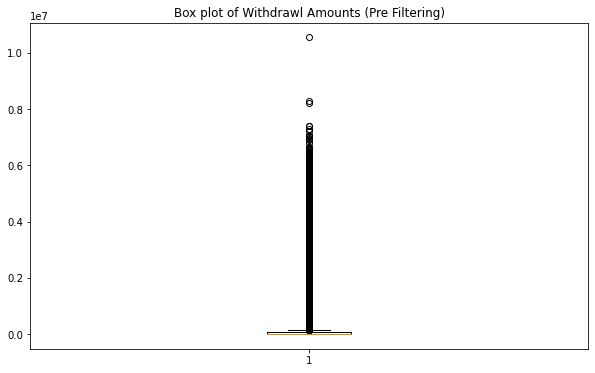

In [9]:
# Boxplot of withdrawl column before removing outliers
plt.figure(figsize=(10, 6))
plt.title("Box plot of Withdrawl Amounts (Pre Filtering)")
plt.boxplot(df["Withdrawls"])
plt.show()

* From the boxplot, we can see a lot of outliers in this data but we must keep in mind that this financial statement might belong to a user who deals with large amounts of cash in single transactions. 
* We can observe four points that stray far from the other points, which have a high possibility of being outliers 
* To avoid incorrect assumptions, we can remove the 1% and 99% quantile just to be safe as well as improve the accuracy, even if it is a small improvement 

1st Quantile (Withdrawls): 0.0
99th Quantile (Withdrawls): 1323891.784699994


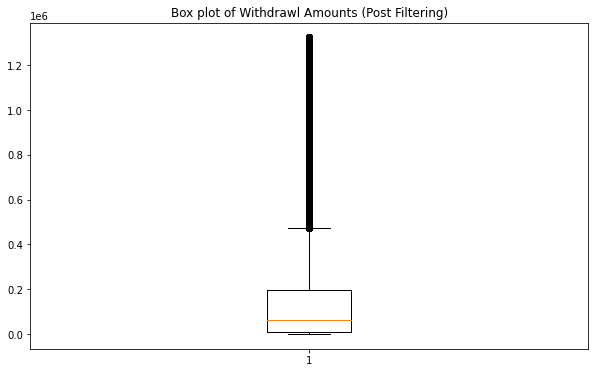

In [10]:
# Calculate the 1% and 99% quantiles to identify outlier values
q_low = df["Withdrawls"].quantile(0.01) # Find the largest value that occurs 1% of the time
q_hi  = df["Withdrawls"].quantile(0.99) # Find the largest value that occurs 99% of the time

# Print out calculated quantiles
print('1st Quantile (Withdrawls): {0}'.format(q_low))
print('99th Quantile (Withdrawls): {0}'.format(q_hi))

# Create a dataframe without these outliers
df_filtered = df[(df["Withdrawls"] > q_low) & (df["Withdrawls"] < q_hi)]
df_filtered

# Boxplot of the new dataframe after removing the outliers more than the 99% quantile and less than the 1% quantile
plt.figure(figsize=(10, 6))
plt.title("Box plot of Withdrawl Amounts (Post Filtering)")
plt.boxplot(df_filtered["Withdrawls"])
plt.show()

* Eventhough we can still see a lot of outliers, the four points that were far away from the other points are removed. 
* The remaining outliers are so close to each other that we can assume that they are useful for our model, for now

### 3. Building the Linear Regression Model (Predict maximum expenditure for the next year)
* To improve budgeting, we can predict the maximum expenditure of each year, which is of lower granularity but we will increase it  later when we build the model based on the month as well.  
* If the predicted maximum expenditure is larger next year, it is a sign that the user should probably not take more money out of the bank anytime soon.

In [11]:
# Initialise new dataframe,  df_maxperyear with Year and Month columns of df
df_maxperyear = df_filtered[['Year','Month']]

# Group dataframe by Year then by Month, 
# and then get the maximum withdrawl amounts for each month in each year
df_maxperyear['Max Withdrawls (thousands)'] = df_filtered.groupby(['Year'])['Withdrawls'].transform('max') / 1000

# Drop duplicates of same months to get maximum withdrawls of each month
df_maxperyear = df_maxperyear.drop_duplicates(subset=['Year'])

# Display the modified dataframe showing the maximum withdrawls every year
df_maxperyear.drop(columns=['Month'], inplace=True)
df_maxperyear

C:\Users\User\AppData\Local\Temp\ipykernel_20300\3891495540.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_maxperyear['Max Withdrawls (thousands)'] = df_filtered.groupby(['Year'])['Withdrawls'].transform('max') / 1000
C:\Users\User\AppData\Local\Temp\ipykernel_20300\3891495540.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_maxperyear.drop(columns=['Month'], inplace=True)


,Year,Max Withdrawls (thousands)
0,2020,1320.64367
12191,2021,1323.66862
49474,2022,1322.64594
84996,2023,1320.42830
120010,2024,1323.61983
...,...,...
4819357,2151,1323.87332
4856577,2152,1320.90459
4891912,2153,1323.74486
4929116,2154,1321.77858


[]

<Figure size 720x576 with 0 Axes>

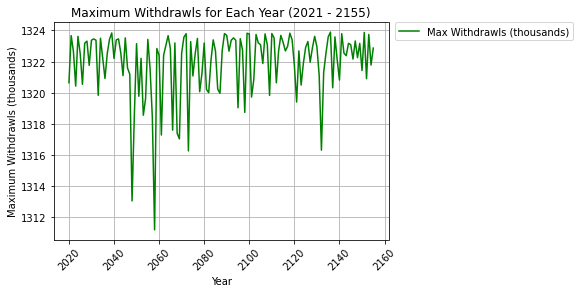

In [23]:
# Plot line graph of Year-Month against Max Withdrawls
plt.figure(figsize=(10,8))
df_maxperyear.plot(x='Year', y='Max Withdrawls (thousands)', xlabel = 'Year', ylabel = 'Maximum Withdrawls (thousands)', title = 'Maximum Withdrawls for Each Year (2021 - 2155)', rot=45, color = 'green')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.grid(visible=True)
plt.plot()

In [13]:
# Build the linear regression model based on the transformed data of maximum withdrawls for each year
linear_regressor_peryear = LinearRegression()  # create object for the class LinearRegression

# Reshape the Year and Max Withdrawls (thousands) columns so that it is suitable for the model to be trained
X = df_maxperyear.iloc[:, 0].values.reshape(-1, 1) 
Y = df_maxperyear.iloc[:, 1].values.reshape(-1, 1)

# Fit the year and max withdrawls data to the model
linear_regressor_peryear.fit(X, Y)

# Run the model with the Year values as the argument to predict the expenditure for each year
Y_pred = linear_regressor_peryear.predict(X)

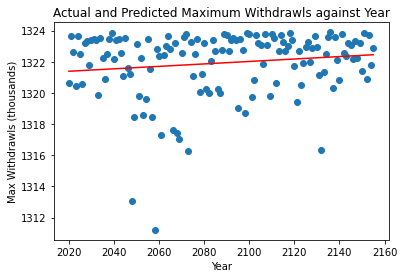

In [14]:
# Plot the original cleaned data and the predicted data 
plt.scatter(X, Y)
plt.title("Actual and Predicted Maximum Withdrawls against Year")
plt.xlabel("Year")
plt.ylabel("Max Withdrawls (thousands)")
plt.plot(X, Y_pred, color='red')
plt.show()

* We can see the linear regression model has assumed a linear relationship between the year and maximum withdrawls, where we can see the linear shape by the red line plotted.

#### Next, we can observe the coefficients of the model, namely the slope (gradient) and the y-intercept 

In [15]:
print("Slope : " + str(linear_regressor_peryear.coef_[0][0]) + "\n" + "Intercept : " + str(linear_regressor_peryear.intercept_[0]))

Slope : 0.007859734984017933
Intercept : 1305.5106488090978


* The <b>gradient</b> of the linear regression model is a small, positive numeric value which indicates that the <b>maximum expenditure</b> of this user <b>has been and is predicted to be increasing<b> as the years go by.
<br>
* The <b>y-intercept</b> is the Maximum Withdrawl value when the model line graph touches the y-axis

#### Let's write a function that can predict the maximum withdrawl for any year based on the model 

In [16]:
def predict_next_year(slope, intercept, year):
    return slope*year+intercept

# Testing the model: Predict the maximum expenditure in the year 2048
year = 2048
predicted_max = predict_next_year(linear_regressor_peryear.coef_, linear_regressor_peryear.intercept_, year)
print("Prediction of maximum expenditure for the year " + str(year) + " is $" + str(round(predicted_max[0][0] * 1000,2))) 

# Testing the model: Predict the maximum expenditure in the year 2050
year = 2050
predicted_max = predict_next_year(linear_regressor_peryear.coef_, linear_regressor_peryear.intercept_, year)
print("Prediction of maximum expenditure for the year " + str(year) + " is $" + str(round(predicted_max[0][0] * 1000,2)))

Prediction of maximum expenditure for the year 2048 is $1321607.39
Prediction of maximum expenditure for the year 2050 is $1321623.11


* We can observe that the maximum expenditure for the year 2050 increases slightly from the value predicted in the year 2048. 
* This is expected since the slope (gradient) is a small positive value as mentioned before and therefore future predicted values should increase in the same manner.

### 4. Building the Linear Regression Model (Predict maximum expenditure for the next month)
- Let's predict the maximum expenditure at a higher granularity, that is for the next month based on a year.
- We can show that by building a Linear Regression model for the year 2155 (which is the only year in the dataset that does not have data recorded for every month.
- The difference with this model from the one we built in Section 3 is that to predict a future month in that year, the model needs to have some actual data on the maximum withdrawls (expenditures) for the previous month(s) in the same year. 

In [37]:
# Initialise new dataframe,  df_maxperyear with Year and Month columns of df
df_maxpermonth = df[['Year','Month']]

# Group dataframe by Year then by Month, 
# and then get the max for each month in each year
df_maxpermonth['Max Withdrawls (thousands)'] = df.groupby(['Year', 'Month'])['Withdrawls'].transform('max') / 1000

# Drop duplicates of same months to get maximum withdrawls of each month
# https://stackoverflow.com/questions/19377969/combine-two-columns-of-text-in-pandas-dataframe
df_maxpermonth = df_maxpermonth.drop_duplicates(subset=['Year', 'Month'])

# Only keep the maximum withdrawls per month data for the year 2155
df_maxpermonth2155 = df_maxpermonth[df_maxpermonth['Year'] == 2155]
df_maxpermonth2155

,Year,Month,Max Withdrawls (thousands)
4966753,2155,1,4511.41953
4970620,2155,2,4998.70641
4973949,2155,3,3535.50979
4977204,2155,4,4438.18910
4980157,2155,5,3681.95447
4982787,2155,6,2524.11321
4986026,2155,7,5014.49800
4988866,2155,8,3825.98286
4992131,2155,9,3582.92086
4995435,2155,10,2739.20400


[]

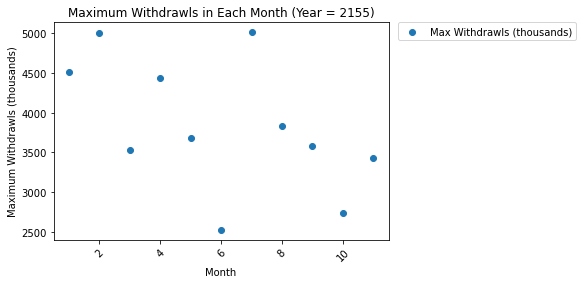

In [62]:
# Plot line graph of Year-Month against Max Withdrawls for the year 2155
plt.scatter(df_maxpermonth2155['Month'], df_maxpermonth2155['Max Withdrawls (thousands)'])
plt.xlabel('Month')
plt.ylabel('Maximum Withdrawls (thousands)')
plt.title('Maximum Withdrawls in Each Month (Year = 2155)')
plt.xticks(rotation = 45)
plt.legend(['Max Withdrawls (thousands)'], bbox_to_anchor=(1.56, 1), loc='upper right', borderaxespad=0)
plt.plot()

In [63]:
linear_regressor_year2155 = LinearRegression()  # create object for the class

# Reshape the Month and Max Withdrawls (thousands) columns so that it is suitable for the model to be trained
X_year2155 = df_maxpermonth2155.iloc[:, 1].values.reshape(-1, 1)
Y_year2155 = df_maxpermonth2155.iloc[:, 2].values.reshape(-1, 1)

# Fit the month and max withdrawls data to the model
linear_regressor_year2155.fit(X_year2155, Y_year2155)

# Run the model with the Month values as the argument to predict the expenditure for each month in the year 2155
Y_pred_year2155 = linear_regressor_year2155.predict(X_year2155)  # make predictions

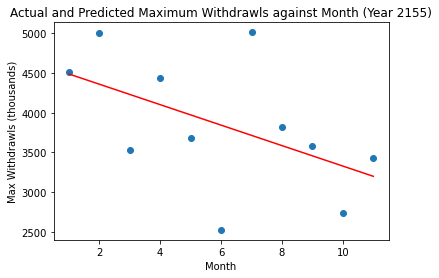

In [65]:
# Plot the original cleaned data and the predicted data 
plt.scatter(X_year2155, Y_year2155)
plt.title("Actual and Predicted Maximum Withdrawls against Month (Year 2155)")
plt.xlabel("Month")
plt.ylabel("Max Withdrawls (thousands)")
plt.plot(X_year2155, Y_pred_year2155, color='red')
plt.show()

In [32]:
print("Slope : " + str(linear_regressor_year2155.coef_[0][0]) + "\n" + "Intercept : " + str(linear_regressor_year2155.intercept_[0]))

Slope : -128.91053800000003
Intercept : 4617.591864363636


* The <b>gradient</b> of the linear regression model is a large, negative numeric value which indicates that the <b>maximum expenditure</b> of this user <b>has been and is predicted to be decreasing significantly<b> as the months go by.
<br>
* The <b>y-intercept</b> is the Maximum Withdrawl value when the model line graph touches the y-axis

#### Let's write a function that can predict the maximum withdrawl for any month in the year 2155 based on the model 

In [86]:
def predict_next_month(slope, intercept, month):
    return slope*month+intercept

# Testing the model: Note down the maximum expenditure in the month of November (11th month) in the year 2155
max_month11 = df_maxpermonth2155[(df_maxpermonth2155['Year'] == 2155) & (df_maxpermonth2155['Month'] == 11)]['Max Withdrawls (thousands)'].values[0]
print("Maximum expenditure for the month 11 is $" + str(round(max_month11*1000,2)))

# Testing the model: Predict the maximum expenditure in the month of December (12th month) in the year 2155
month = 12
predicted_max = predict_next_month(linear_regressor_year2155.coef_, linear_regressor_year2155.intercept_, month)
print("Prediction of maximum expenditure for the month " + str(month) + " is $" + str(round(predicted_max[0][0] * 1000,2))) 

Maximum expenditure for the month 11 is $3432916.77
Prediction of maximum expenditure for the month 12 is $3070665.41


* We can observe that the predicted maximum expenditure for the month of December decreased significantly from the value recorded in the month of November. 
* This is expected since the slope (gradient) is a large, negativ value as mentioned before and therefore future predicted values should decrease in the same manner.